In [46]:
from time import time
import numpy as np

from sklearn import svm
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn import datasets

In [47]:
import sys
import os
# sys.path.append("../include/")
basePath = os.getcwd()
basePath = os.path.split(basePath)[0]
basePath = os.path.split(basePath)[0]
sys.path.append(os.path.join(basePath, "include"))
print(basePath)

/home/itmal28/IKT-MAL


In [48]:
from libitmal import dataloaders_v3 as itmaldataloaders

#%%
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

data_csv_path =  basePath + "/Slutprojekt/DatafordelingPlot/spotifyDBData_preprocessed_minmaxscaled.csv"
data_csv_path_onehot = basePath + "/Slutprojekt/DatafordelingPlot/spotifyDBData_preprocessed_minmaxscaled_onehotenc-all.csv"
data_csv_path_onehot_mode_tsig = basePath + "/Slutprojekt/DatafordelingPlot/spotifyDBData_preprocessed_minmaxscaled_onehotenc-mode-tsig.csv"
data_csv_path_onehot_mode_tsig_stdscaled = basePath + "/Slutprojekt/DatafordelingPlot/spotifyDBData_preprocessed_stdscaled_onehotenc-mode-tsig.csv"

def loadPreprocessed():
    return pd.read_csv(data_csv_path, sep=',', header=0)

def loadPreprocessedOnehotenc():
    return pd.read_csv(data_csv_path_onehot, sep=',', header=0)

def loadPreprocessedModeTsigOnehotenc():
    return pd.read_csv(data_csv_path_onehot_mode_tsig, sep=',', header=0)

def loadPreprocessedModeTsigOnehotencStdScaled():
    return pd.read_csv(data_csv_path_onehot_mode_tsig_stdscaled, sep=',', header=0)

all_genres = ['Alternative', 'Anime', 'Blues', 'Children’s Music', 'Classical', 'Comedy',
 'Country', 'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Movie',
 'Opera', 'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul',
 'Soundtrack', 'World']

regular_input_features = [
    "popularity", "acousticness", "danceability",
    "energy", "instrumentalness",  "liveness", "loudness", "speechiness",
    "tempo", "valence"
]

onehot_input_features = [
    "mode_major", "mode_minor",
    "time_signature_3-4", "time_signature_4-4", "time_signature_5-4"
]

def getSpotifyBinarizedXY(remove_cols=None):
    data_filtered = loadPreprocessed()
    if (remove_cols is not None):
        for col in remove_cols:
            data_filtered = data_filtered[data_filtered.genre != col]
    X_df = data_filtered[regular_input_features]
    lb = LabelBinarizer()
    X = np.array(X_df)
    y = lb.fit_transform(np.array(data_filtered['genre']))

    print("Binarized Label to the following classes")
    print(lb.classes_)
    print(lb.classes_.shape[0])

    return X, y

def getSpotifyIntLabeledXY():
    spotifyDBData = loadPreprocessed()
    X = np.array(spotifyDBData[regular_input_features])

    label_encoder = LabelEncoder() 
    y = label_encoder.fit_transform(spotifyDBData['genre']) 

    return X, y

def getSpotifyOneHotEncXY():
    spotifyDBData = loadPreprocessedModeTsigOnehotenc()
    input_features = regular_input_features + onehot_input_features
    X = np.array(spotifyDBData[input_features])

    y = LabelEncoder().fit_transform(spotifyDBData['genre']) 
    return X, y

def getSpotifyOneHotEncStdScaledXY():
    spotifyDBData = loadPreprocessedModeTsigOnehotencStdScaled()
    input_features = regular_input_features + onehot_input_features
    X = np.array(spotifyDBData[input_features])

    y = LabelEncoder().fit_transform(spotifyDBData['genre']) 
    return X, y

#%%
currmode="N/A" # GLOBAL var!

def SearchReport(model): 
    
    def GetBestModelCTOR(model, best_params):
        def GetParams(best_params):
            r=""          
            for key in sorted(best_params):
                value = best_params[key]
                t = "'" if str(type(value))=="<class 'str'>" else ""
                if len(r)>0:
                    r += ','
                r += f'{key}={t}{value}{t}'  
            return r            
        try:
            p = GetParams(best_params)
            return type(model).__name__ + '(' + p + ')' 
        except:
            return "N/A(1)"
        
    print("\nBest model set found on train set:")
    print()
    print(f"\tbest parameters={model.best_params_}")
    print(f"\tbest '{model.scoring}' score={model.best_score_}")
    print(f"\tbest index={model.best_index_}")
    print()
    print(f"Best estimator CTOR:")
    print(f"\t{model.best_estimator_}")
    print()
    try:
        print(f"Grid scores ('{model.scoring}') on development set:")
        means = model.cv_results_['mean_test_score']
        stds  = model.cv_results_['std_test_score']
        i=0
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("\t[%2d]: %0.3f (+/-%0.03f) for %r" % (i, mean, std * 2, params))
            i += 1
    except:
        print("WARNING: the random search do not provide means/stds")
    
    global currmode                
    assert "f1_micro"==str(model.scoring), f"come on, we need to fix the scoring to be able to compare model-fits! Your scoreing={str(model.scoring)}...remember to add scoring='f1_micro' to the search"   
    return f"best: dat={currmode}, score={model.best_score_:0.5f}, model={GetBestModelCTOR(model.estimator,model.best_params_)}", model.best_estimator_ 

def ClassificationReport(model, X_test, y_test, target_names=None):
    assert X_test.shape[0]==y_test.shape[0]
    print("\nDetailed classification report:")
    print("\tThe model is trained on the full development set.")
    print("\tThe scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)                 
    print(classification_report(y_true, y_pred, target_names))
    print()
    
def FullReport(model, X_test, y_test, t):
    print(f"SEARCH TIME: {t:0.2f} sec")
    beststr, bestmodel = SearchReport(model)
    ClassificationReport(model, X_test, y_test)    
    print(f"CTOR for best model: {bestmodel}\n")
    print(f"{beststr}\n")
    return beststr, bestmodel
    
def LoadAndSetupData(mode, test_size=0.3):
    assert test_size>=0.0 and test_size<=1.0
    
    def ShapeToString(Z):
        n = Z.ndim
        s = "("
        for i in range(n):
            s += f"{Z.shape[i]:5d}"
            if i+1!=n:
                s += ";"
        return s+")"

    global currmode
    currmode=mode
    print(f"DATA: {currmode}..")
    
    if mode=='moon':
        X, y = itmaldataloaders.MOON_GetDataSet(n_samples=5000, noise=0.2)
        itmaldataloaders.MOON_Plot(X, y)
    elif mode=='mnist':
        X, y = itmaldataloaders.MNIST_GetDataSet(fetchmode=False)
        if X.ndim==3:
            X=np.reshape(X, (X.shape[0], -1))
    elif mode=='iris':
        X, y = itmaldataloaders.IRIS_GetDataSet()
    elif mode=='spotify_binarized':
        #remove_cols = ['Alternative', 'Anime', 'Blues', 'Children’s Music', 'Classical', 'Comedy',
            # 'Country', 'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Movie',
            # 'Opera', 'Pop', 'R&B', 'Reggae', 'Reggaeton']
        remove_cols = None
        X, y = getSpotifyBinarizedXY(remove_cols)
    elif mode=='spotify_intlabels':
        X, y = getSpotifyIntLabeledXY()
    elif mode=='spotify_onehotin_labelout':
        X, y = getSpotifyOneHotEncXY()
    elif mode=='spotify_onehotin_labelout_std':
        X, y = getSpotifyOneHotEncStdScaledXY()
    else:
        raise ValueError(f"could not load data for that particular mode='{mode}'")
        
    print(f'  org. data:  X.shape      ={ShapeToString(X)}, y.shape      ={ShapeToString(y)}')

    assert X.ndim==2
    assert X.shape[0]==y.shape[0]
    # assert y.ndim==1 or (y.ndim==2 and y.shape[1]==0)    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=0, shuffle=True
    )
    
    print(f'  train data: X_train.shape={ShapeToString(X_train)}, y_train.shape={ShapeToString(y_train)}')
    print(f'  test data:  X_test.shape ={ShapeToString(X_test)}, y_test.shape ={ShapeToString(y_test)}')
    print()
    
    return X_train, X_test, y_train, y_test

print('OK')


OK


In [49]:
#%% -----------------------------------
#   Neural Network
# -------------------------------------

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn import datasets

import numpy as np
from time import time

np.random.seed(42)

X_train, X_test, y_train, y_test = LoadAndSetupData('spotify_onehotin_labelout')

y_train_binary = to_categorical(y_train)
y_test_binary  = to_categorical(y_test)

assert y_train_binary.ndim==2
assert y_test_binary.ndim ==2

DATA: spotify_onehotin_labelout..
  org. data:  X.shape      =(222593;   15), y.shape      =(222593)
  train data: X_train.shape=(155815;   15), y_train.shape=(155815)
  test data:  X_test.shape =(66778;   15), y_test.shape =(66778)



In [50]:
from keras import backend as K

def recall_m(y, y_pred,**kwargs):
        true_positives = K.sum(K.round(K.clip(y * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y, y_pred, **kwargs):
        true_positives = K.sum(K.round(K.clip(y * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y, y_pred, **kwargs):
    precision = precision_m(y, y_pred)
    recall = recall_m(y, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# # fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

# # evaluate the model
# loss, accuracy, f1_score, precision, recall = model.evaluate(Xtest, ytest, verbose=0)

#%%

# Build Keras model 
model = Sequential()
model.add(Dense(input_dim=15, units=20, activation="tanh", kernel_initializer="normal"))
model.add(Dense(units=25, activation="softmax"))

#optimizer = SGD(lr=0.1)
optimizer = Adam(lr=0.1)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['acc', f1_m, precision_m, recall_m])

# Train
VERBOSE     = 10
EPOCHS      = 35

start = time()
history = model.fit(X_train, y_train_binary, 
    validation_data=(X_test, y_test_binary), 
    epochs=EPOCHS, verbose=VERBOSE)
t = time()-start

print(f"OK, training time={t:0.1f}")


#%%
# score = model.evaluate(X_test, y_test_binary, verbose=0)

# print(f"Training time: {t:0.1f} sec")
# print({score[0]}) # loss is score 0 by definition?
# print({score[1]})
# print(f"All scores in history: {score}")

loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test_binary, verbose=10)
print("loss: " + str(loss))
print("accuracy: " + str(accuracy))
print("f1_score: " + str(f1_score))
print("precision: " + str(precision))
print("recall: " + str(recall))

# from sklearn.metrics import classification_report

# y_pred = model.predict(x_test, batch_size=64, verbose=1)
# y_pred_bool = np.argmax(y_pred, axis=1)

# print(classification_report(y_test, y_pred_bool))

Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=332.2
loss: 2.4776479798887947
accuracy: 0.30033843481430716
f1_score: 0.25866043796737886
precision: 0.43285903281776933
recall: 0.18679804726129715


In [ ]:
###########
# Batch size test
###########

def createModel():
    model = Sequential()
    model.add(Dense(input_dim=15, units=20, activation="tanh", kernel_initializer="normal"))
    model.add(Dense(units=25, activation="softmax"))

    #optimizer = SGD(lr=0.1)
    optimizer = Adam(lr=0.1)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['acc', f1_m, precision_m, recall_m])
    return model


# Train
VERBOSE     = 10
EPOCHS      = 35
np.random.seed(42)

batch_size = [10, 20, 40, 60, 80, 100, 200, 400, 600, 800, 1000]
results = {}

for bs in batch_size:
    
    model = createModel()
    
    start = time()
    history = model.fit(X_train, y_train_binary, 
        validation_data=(X_test, y_test_binary), 
        epochs=EPOCHS, verbose=VERBOSE, batch_size=bs)
    t = time()-start

    print(f"OK, training time={t:0.1f} for {bs} batch_size:")
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test_binary, verbose=10)
    print("loss: " + str(loss))
    print("accuracy: " + str(accuracy))
    print("f1_score: " + str(f1_score))
    print("precision: " + str(precision))
    print('---------------------------------------')
    results[bs] = f1_score
    
for bs in batch_size:
    print(f"{bs}: {results[bs]}")

In [25]:
###########
# Neuron test
###########

def createModel(neurons):
    model = Sequential()
    model.add(Dense(input_dim=15, units=neurons, activation="tanh", kernel_initializer="normal"))
    model.add(Dense(units=25, activation="softmax"))

    #optimizer = SGD(lr=0.1)
    optimizer = Adam(lr=0.1)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['acc', f1_m, precision_m, recall_m])
    return model


# Train
VERBOSE     = 10
EPOCHS      = 35
np.random.seed(42)

neurons = [1, 2, 3, 4, 5 , 6 , 7, 8, 9, 10, 11, 12, 13, 14, 15,
          16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 50, 100, 150]
results = {}

for n in neurons:
    
    model = createModel(n)
    
    start = time()
    history = model.fit(X_train, y_train_binary, 
        validation_data=(X_test, y_test_binary), 
        epochs=EPOCHS, verbose=VERBOSE, batch_size=800)
    t = time()-start

    print(f"OK, training time={t:0.1f} for {n} neurons:")
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test_binary, verbose=10)
    print("loss: " + str(loss))
    print("accuracy: " + str(accuracy))
    print("f1_score: " + str(f1_score))
    print("precision: " + str(precision))
    print('---------------------------------------')
    results[str(n)] = f1_score
    
for n in neurons:
    print(f"{n}: {results[n]}")

Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=16.6 for 1 neurons:
loss: 2.601920087481235
accuracy: 0.1668214082484486
f1_score: 0.030361180881872812
precision: 0.36466298302841793
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epo

Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=19.4 for 13 neurons:
loss: 1.9144975115815963
accuracy: 0.36648297343704234
f1_score: 0.24173369960588686
precision: 0.7110206827937712
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=19.7 for 14 neurons:
loss: 1.9003381900358345
accuracy: 0.3723831201919616
f1_score: 0.2521652450231698
precision: 0.7036328917743739
---------------------------------------
Train on 155815 samples, validate on 66778 s

Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=23.6 for 50 neurons:
loss: 1.9066547078654152
accuracy: 0.37241307017415026
f1_score: 0.30227530381493806
precision: 0.6130608093735342
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoc

KeyError: 1

In [31]:
#####################
# HIDDEN LAYER ACTIVATION
#####################

def createModel(activation):
    model = Sequential()
    model.add(Dense(input_dim=15, units=50, activation=activation, kernel_initializer="normal"))
    model.add(Dense(units=25, activation="softmax"))

    #optimizer = SGD(lr=0.1)
    optimizer = Adam(lr=0.1)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['acc', f1_m, precision_m, recall_m])
    return model


# Train
VERBOSE     = 10
EPOCHS      = 35
np.random.seed(42)

activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
results = {}

for n in activation:
    
    model = createModel(n)
    
    start = time()
    history = model.fit(X_train, y_train_binary, 
        validation_data=(X_test, y_test_binary), 
        epochs=EPOCHS, verbose=VERBOSE, batch_size=800)
    t = time()-start

    print(f"OK, training time={t:0.1f} for {n} neurons:")
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test_binary, verbose=10)
    print("loss: " + str(loss))
    print("accuracy: " + str(accuracy))
    print("f1_score: " + str(f1_score))
    print("precision: " + str(precision))
    print('---------------------------------------')
    results[bs] = f1_score
    
for n in activation:
    print(f"{n}: {results[n]}")

Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=24.9 for softmax neurons:
loss: 1.858355028673789
accuracy: 0.38638473748884067
f1_score: 0.28052685407753697
precision: 0.6999613653599882
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/3

KeyError: 1

In [51]:
########
# KERNEL_INITIALIZER
########

def createModel(init_mode):
    model = Sequential()
    model.add(Dense(input_dim=15, units=50, activation='sigmoid', kernel_initializer=init_mode))
    model.add(Dense(units=25, activation='sigmoid', kernel_initializer=init_mode))

    #optimizer = SGD(lr=0.1)
    optimizer = Adam(lr=0.1)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['acc', f1_m, precision_m, recall_m])
    return model


# Train
VERBOSE     = 10
EPOCHS      = 35
np.random.seed(42)

init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
results = {}

for n in init_mode:
    
    model = createModel(n)
    
    start = time()
    history = model.fit(X_train, y_train_binary, 
        validation_data=(X_test, y_test_binary), 
        epochs=EPOCHS, verbose=VERBOSE, batch_size=800)
    t = time()-start

    print(f"OK, training time={t:0.1f} for {n} neurons:")
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test_binary, verbose=10)
    print("loss: " + str(loss))
    print("accuracy: " + str(accuracy))
    print("f1_score: " + str(f1_score))
    print("precision: " + str(precision))
    print('---------------------------------------')
    results[bs] = f1_score
    
for n in init_mode:
    print(f"{n}: {results[n]}")

Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=32.1 for uniform neurons:
loss: 1.8096082093934243
accuracy: 0.3975411063528378
f1_score: 0.32238362511090685
precision: 0.35650123216736407
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/

KeyError: 'uniform'

In [57]:
#########
# OPTIMIZER
##########

from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam, SGD

def createModel(optimizer):
    model = Sequential()
    model.add(Dense(input_dim=15, units=50, activation='sigmoid', kernel_initializer="he_uniform"))
    model.add(Dense(units=25, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['acc', f1_m, precision_m, recall_m])
    return model


# Train
VERBOSE     = 10
EPOCHS      = 35
np.random.seed(42)

optimizer = [SGD(lr=0.1), RMSprop(lr=0.1), Adagrad(lr=0.1), Adadelta(lr=0.1), Adam(lr=0.1), Adamax(lr=0.1), Nadam(lr=0.1)]
results = {}

for n in optimizer:
    
    model = createModel(n)
    
    start = time()
    history = model.fit(X_train, y_train_binary, 
        validation_data=(X_test, y_test_binary), 
        epochs=EPOCHS, verbose=VERBOSE, batch_size=800)
    t = time()-start

    print(f"OK, training time={t:0.1f} for {n} neurons:")
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test_binary, verbose=10)
    print("loss: " + str(loss))
    print("accuracy: " + str(accuracy))
    print("f1_score: " + str(f1_score))
    print("precision: " + str(precision))
    print('---------------------------------------')
    results[bs] = f1_score
    
for n in neurons:
    print(f"{n}: {results[n]}")

Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=33.5 for <keras.optimizers.SGD object at 0x7f15a5dabc18> neurons:
loss: 1.97692041729634
accuracy: 0.36309862530021897
f1_score: 0.03516148773071283
precision: 0.4189563091883259
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 2

KeyError: 1

In [23]:
#Batch size test

def createModel():
    model = Sequential()
    model.add(Dense(input_dim=15, units=20, activation="tanh", kernel_initializer="normal"))
    model.add(Dense(units=25, activation="softmax"))

    #optimizer = SGD(lr=0.1)
    optimizer = Adam(lr=0.1)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['acc', f1_m, precision_m, recall_m])
    return model


# Train
VERBOSE     = 10
EPOCHS      = 35
np.random.seed(42)

epochs = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]
results = {}

for ep in epochs:
    
    model = createModel()
    
    start = time()
    history = model.fit(X_train, y_train_binary, 
        validation_data=(X_test, y_test_binary), 
        epochs=ep, verbose=VERBOSE, batch_size=800)
    t = time()-start

    print(f"OK, training time={t:0.1f} for {ep} batch_size:")
    loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test_binary, verbose=10)
    print("loss: " + str(loss))
    print("accuracy: " + str(accuracy))
    print("f1_score: " + str(f1_score))
    print("precision: " + str(precision))
    print('---------------------------------------')
    results[ep] = f1_score
    
for ep in epochs:
    print(f"{ep}: {results[ep]}")

Train on 155815 samples, validate on 66778 samples
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
OK, training time=5.9 for 10 batch_size:
loss: 1.8778598561020294
accuracy: 0.37742969241813207
f1_score: 0.2760809580179169
precision: 0.69589550321309
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
OK, training time=10.3 for 20 batch_size:
loss: 1.8983120191000504
accuracy: 0.368953847079847
f1_score: 0.2676126493079746
precision: 0.6620148886277986
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 1

Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78/100
Epoch 79/100
Epoch 80/100
Epoch 81/100
Epoch 82/100
Epoch 83/100
Epoch 84/100
Epoch 85/100
Epoch 86/100
Epoch 87/100
Epoch 88/100
Epoch 89/100
Epoch 90/100
Epoch 91/100
Epoch 92/100
Epoch 93/100
Epoch 94/100
Epoch 95/100
Epoch 96/100
Epoch 97/100
Epoch 98/100
Epoch 99/100
Epoch 100/100
OK, training time=46.7 for 100 batch_size:
loss: 1.886673886148523
accuracy: 0.3751684686626977
f1_score: 0.27447562478532933
precision: 0.6754011599819895
---------------------------------------
Train on 155815 samples, validate on 66778 samples
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoc

In [59]:
########## FINAL NN

def createModel():
    model = Sequential()
    model.add(Dense(input_dim=15, units=50, activation="sigmoid", kernel_initializer="he_uniform"))
    model.add(Dense(units=25, activation="sigmoid"))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.1), 
                  metrics=['acc', f1_m, precision_m, recall_m])
    return model


model = createModel()

start = time()
history = model.fit(X_train, y_train_binary, 
    validation_data=(X_test, y_test_binary), 
    epochs=35, verbose=VERBOSE, batch_size=800)
t = time()-start

print(f"OK, training time={t:0.1f} for {ep} batch_size:")
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test_binary, verbose=10)
print("loss: " + str(loss))
print("accuracy: " + str(accuracy))
print("f1_score: " + str(f1_score))
print("precision: " + str(precision))
print('---------------------------------------')

Train on 155815 samples, validate on 66778 samples
Epoch 1/35
Epoch 2/35
Epoch 3/35
Epoch 4/35
Epoch 5/35
Epoch 6/35
Epoch 7/35
Epoch 8/35
Epoch 9/35
Epoch 10/35
Epoch 11/35
Epoch 12/35
Epoch 13/35
Epoch 14/35
Epoch 15/35
Epoch 16/35
Epoch 17/35
Epoch 18/35
Epoch 19/35
Epoch 20/35
Epoch 21/35
Epoch 22/35
Epoch 23/35
Epoch 24/35
Epoch 25/35
Epoch 26/35
Epoch 27/35
Epoch 28/35
Epoch 29/35
Epoch 30/35
Epoch 31/35
Epoch 32/35
Epoch 33/35
Epoch 34/35
Epoch 35/35
OK, training time=34.8 for 200 batch_size:
loss: 1.8006537508359728
accuracy: 0.40007187996492893
f1_score: 0.32930593811982606
precision: 0.370056784857408
---------------------------------------


In [99]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

y_pred = model.predict(X_test)

<IPython.core.display.Javascript object>


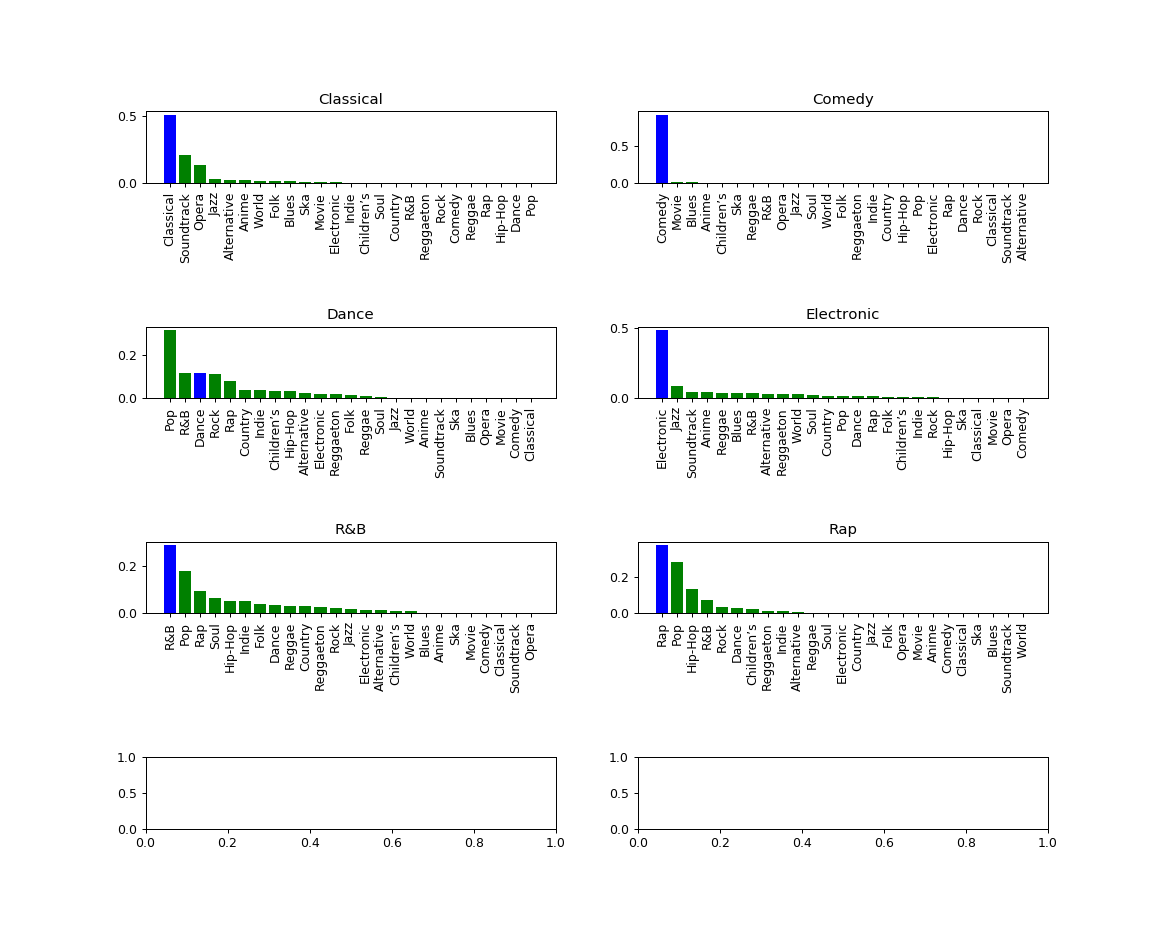

In [111]:
all_genres = ['Alternative', 'Anime', 'Blues', 'Children’s Music', 'Classical', 'Comedy',
 'Country', 'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Movie',
 'Opera', 'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton', 'Rock', 'Ska', 'Soul',
 'Soundtrack', 'World']

%matplotlib notebook

def getPredictionDistributionData(y_true, y_pred, genre_name):
    genre_index = {gname: i for i, gname in enumerate(all_genres)}
    genre_names = {i: gname for i, gname in enumerate(all_genres)}
    genre_i = genre_index[genre_name]
    
    pred_genre = np.array([
        pred for i, pred in enumerate(y_pred) if y_true[i][genre_i] == 1
    ])
    
    pred_genre = [
        pred_genre[i].argmax() for i, _ in enumerate(pred_genre)
    ]
    
    n_predictions = len(pred_genre)
    pred_genre_dist = pd.DataFrame([
        [i, genre_names[i], (pred_genre.count(i) /  n_predictions) ]
        for i in range(25)
    ], columns=['genre_index', 'genre_name', 'count'])

    sorted_df = pred_genre_dist.sort_values(by=['count'], ascending=False)
    x, y = np.arange(25), sorted_df['count']
    names = sorted_df['genre_name'].reset_index(drop=True)

    color_this, color_other = 'blue', 'green'
    colors= [color_this if names[i] == genre_name else color_other for i in range(25) ]

    names = names.replace("Children’s Music", "Children’s")

    return x, y, names, colors
    
def plotPredictionDistributions(genres, y_true, y_pred):

    cols = 2   # How many subplots pr row
    width = 13 # Width of figure
    prop = 0.4 # Subplot proportions, height/width ratio of subfigures

    rows = int(len(genres)/cols)+1
    height = (rows/cols)*width*prop

    fig, ax = plt.subplots(rows, cols, figsize=(width,height))
    plt.subplots_adjust(wspace=0.2, hspace=2)
    for index, genre in enumerate(genres):
        row, col = int(index/cols), index % cols

        x, y, names, colors = getPredictionDistributionData(y_true, y_pred, genre)
        ax[row,col].bar(x, y, color=colors)
        ax[row,col].set_xticks(x)
        ax[row,col].set_xticklabels(names, rotation='vertical')
        ax[row,col].set_title(genre)

genres_to_plot =  [
    'Classical', 'Comedy',
    'Dance', 'Electronic', 'R&B', 'Rap'
]

plotPredictionDistributions(genres_to_plot, y_test_binary, y_pred)


In [179]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [159]:
y_pred_recall = pd.DataFrame(y_pred)
y_pred_recall = pd.Series([y_pred_recall.loc[i].idxmax() for i in range(y_pred_recall.index.size)])


y_true_recall = pd.DataFrame(y_true)
y_true_recall = pd.Series([y_true_recall.loc[i].idxmax() for i in range(y_true_recall.index.size)])

In [180]:
#recall_score_weighted = recall_score(y_true_recall, y_pred_recall, average='weighted')
#recall_score_macro = recall_score(y_true_recall, y_pred_recall, average='macro')

#f1_weighted = f1_score(y_true_recall, y_pred_recall, average='weighted')
#f1_macro = f1_score(y_true_recall, y_pred_recall, average='macro')

prec_macro, recall_macro, f1_macro, support_macro = precision_recall_fscore_support(y_true_recall, y_pred_recall, average='macro')
print("Macro: ")
print("Precision: " + str(prec_macro))
print("Recall:    " + str(recall_macro))
print("f1:        " + str(f1_macro))
print("support:   " + str(support_macro))

prec_w, recall_w, f1_w, support_w = precision_recall_fscore_support(y_true_recall, y_pred_recall, average='weighted')
print("Weighted: ")
print("Precision: " + str(prec_w))
print("Recall:    " + str(recall_w))
print("f1:        " + str(f1_w))
print("support:   " + str(support_w))

acc = accuracy_score(y_true_recall, y_pred_recall)
print("\nAccuarcy: " + str(acc))


Macro: 
Precision: 0.4133360132846604
Recall:    0.4028179618058881
f1:        0.3956888180757732
support:   None
Weighted: 
Precision: 0.40774772454195385
Recall:    0.400071879960466
f1:        0.3917504145129188
support:   None

Accuarcy: 0.400071879960466
